In [2]:
import os
import platform
from IPython.display import clear_output
print(platform.platform())

def resolve_dir(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)

def reset_path(Dir):
    if not os.path.exists(Dir):
        os.mkdir(Dir)
    else:
        os.system('rm -f {}/*'.format( Dir))

macOS-13.4.1-arm64-arm-64bit


In [3]:
import tensorflow as tf
tf.random.set_seed(73)
TPU_INIT = False

if TPU_INIT:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime!')
else:
    !nvidia-smi
;    
print("Tensorflow version " + tf.__version__)

zsh:1: command not found: nvidia-smi
Tensorflow version 2.13.0-rc2


Preprocessing

In [4]:
import cv2
import os
import imageio
import imgaug.augmenters as iaa
import imgaug as ia

IMG_SIZE = 128
ColorChannels = 3

def video_to_frames(video):
    vidcap = cv2.VideoCapture(video)
    
    import math
    rate = math.floor(vidcap.get(3))
    count = 0
    
    ImageFrames = []
    while vidcap.isOpened():
        ID = vidcap.get(1)
        success, image = vidcap.read()
        
        if success:
            if (ID % 7 == 0):
                flip = iaa.Fliplr(1.0)
                zoom = iaa.Affine(scale=1.3)
                random_brightness = iaa.Multiply((1, 1.3))
                rotate = iaa.Affine(rotate=(-25, 25))
                
                image_aug = flip(image = image)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)
                
                rgb_img = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                resized = cv2.resize(rgb_img, (IMG_SIZE, IMG_SIZE))
                ImageFrames.append(resized)
            count+=1
        else:
            break
    
    vidcap.release()
    
    return ImageFrames

In [5]:
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir('/Users/faizahkureshi/Desktop/GAIP Project/violencedataset/NonViolence')), 
              len(os.listdir('/Users/faizahkureshi/Desktop/GAIP Project/violencedataset/NonViolence'))))

we have 
1000 Violence videos 
1000 NonViolence videos


In [6]:
%%time
#tqdm is used here to visulaize the progress of dataset creation
from tqdm import tqdm

VideoDataDir ='/Users/faizahkureshi/Desktop/GAIP Project/violencedataset'
print('we have \n{} Violence videos \n{} NonViolence videos'.format(
              len(os.listdir('/Users/faizahkureshi/Desktop/GAIP Project/violencedataset/NonViolence')), 
              len(os.listdir('/Users/faizahkureshi/Desktop/GAIP Project/violencedataset/NonViolence'))))

X_original = []
y_original = []
CLASSES = ["NonViolence", "Violence"]

for category in os.listdir(VideoDataDir):
    category_path = os.path.join(VideoDataDir, category)
    if os.path.isdir(category_path):
        class_num = CLASSES.index(category)
        try:
            video_list = [video for video in os.listdir(category_path)[:350] if video != '.DS_Store']
            for i, video in enumerate(tqdm(video_list)):
                video_path = os.path.join(category_path, video)
                frames = video_to_frames(video_path)
                for j, frame in enumerate(frames):
                    X_original.append(frame)
                    y_original.append(class_num)
        except OSError as e:
            print(f"Error processing directory: {category_path}. Skipping...")
            continue



we have 
1000 Violence videos 
1000 NonViolence videos


100%|██████████| 350/350 [00:59<00:00,  5.88it/s]

CPU times: user 3min 28s, sys: 5.94 s, total: 3min 34s
Wall time: 1min 20s


In [7]:
import numpy as np
X_original = np.array(X_original).reshape(-1 , IMG_SIZE * IMG_SIZE * 3)
y_original = np.array(y_original)
len(X_original)

13487

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_sample = StratifiedShuffleSplit(n_splits=2, test_size=0.3, random_state=73)

for train_index, test_index in stratified_sample.split(X_original, y_original):
    X_train, X_test = X_original[train_index], X_original[test_index]
    y_train, y_test = y_original[train_index], y_original[test_index]

X_train_nn = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255
X_test_nn = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 3) / 255

Model Training

In [9]:
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pickle
import matplotlib
matplotlib.use("Agg")

In [10]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [15]:
epochs = 50

from keras import regularizers
kernel_regularizer = regularizers.l2(0.0001)

from keras.applications.mobilenet_v2 import MobileNetV2

def load_layers():
    input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, ColorChannels))
    baseModel = MobileNetV2(pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    headModel = baseModel.output   
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)

    for layer in baseModel.layers:
        layer.trainable = False

    print("Compiling model...")
    model.compile(loss="binary_crossentropy",
                    optimizer='adam',
                    metrics=["accuracy"])

    return model

if TPU_INIT:
    with tpu_strategy.scope():
        model = load_layers()
else:
    model = load_layers()

model.summary()

Compiling model...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_

In [16]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

batch_size = 4

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

In [17]:
end_callback = myCallback()

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)

PROJECT_DIR ='/Users/faizahkureshi/Desktop/GAIP Project/RiskDetection'

lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

os.system('rm -rf ./logs/')

import datetime
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

checkpoint_filepath = 'ModelWeights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)


callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]

if TPU_INIT:
    callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]

In [18]:
print('Training head...')
#model.load_weights('./Model_Weights.h5')

history = model.fit(X_train_nn ,y_train, epochs=epochs,
                        callbacks=callbacks,
                        validation_data = (X_test_nn, y_test),
                        batch_size=batch_size)

print('\nRestoring best Weights for MobileNetV2')
model.load_weights(checkpoint_filepath)

Training head...
Epoch 1/50
2360/2360 [==============================] - ETA: 0s - loss: 0.8058 - accuracy: 0.5502
Epoch 1: val_loss improved from inf to 0.70456, saving model to ModelWeights.h5
2360/2360 [==============================] - 65s 27ms/step - loss: 0.8058 - accuracy: 0.5502 - val_loss: 0.7046 - val_accuracy: 0.6140 - lr: 1.0000e-05
Epoch 2/50
2358/2360 [============================>.] - ETA: 0s - loss: 0.6042 - accuracy: 0.6792
Epoch 2: val_loss improved from 0.70456 to 0.52811, saving model to ModelWeights.h5
2360/2360 [==============================] - 62s 26ms/step - loss: 0.6042 - accuracy: 0.6791 - val_loss: 0.5281 - val_accuracy: 0.7401 - lr: 1.8000e-05
Epoch 3/50
2359/2360 [============================>.] - ETA: 0s - loss: 0.4746 - accuracy: 0.7738
Epoch 3: val_loss improved from 0.52811 to 0.43506, saving model to ModelWeights.h5
2360/2360 [==============================] - 60s 25ms/step - loss: 0.4746 - accuracy: 0.7738 - val_loss: 0.4351 - val_accuracy: 0.7994 - 

In [16]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)


def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i
                
def model_summary(model, history):
    print('---'*30)
    test_loss, test_accuracy = model.evaluate(X_test_nn, y_test, verbose=0)

    if history:
        index = get_best_epoch(test_loss, history)
        print('Best Epochs: ', index)

        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print('Accuracy on train:',train_accuracy,'\tLoss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'\tLoss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        print('---'*30)   

------------------------------------------------------------------------------------------
Best Epochs:  12
Accuracy on train: 0.9171609878540039 	Loss on train: 0.21271847188472748
Accuracy on test: 0.9103039503097534 	Loss on test: 0.22530776262283325


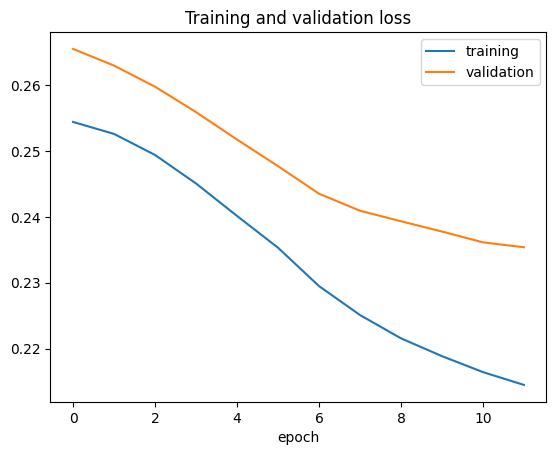

<Figure size 640x480 with 0 Axes>

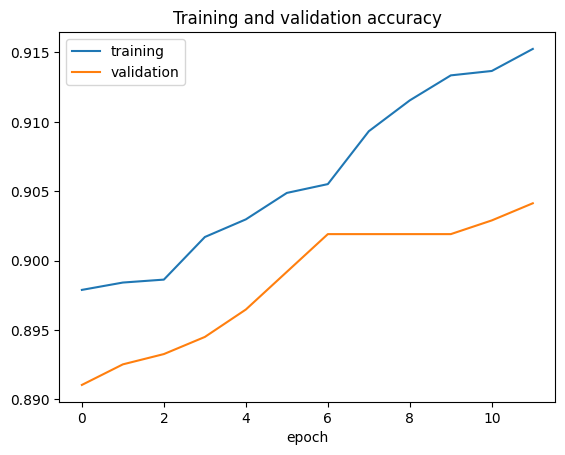

------------------------------------------------------------------------------------------


<Figure size 640x480 with 0 Axes>

In [17]:
model_summary(model, history)

Evaluation on test dataset

In [18]:
# evaluate the network
print("Evaluating network...")
predictions = model.predict(X_test_nn)
preds = predictions > 0.5

Evaluating network...
127/127 [==============================] - 10s 79ms/step


In [ ]:
from scikitplot.metrics import plot_roc_curve

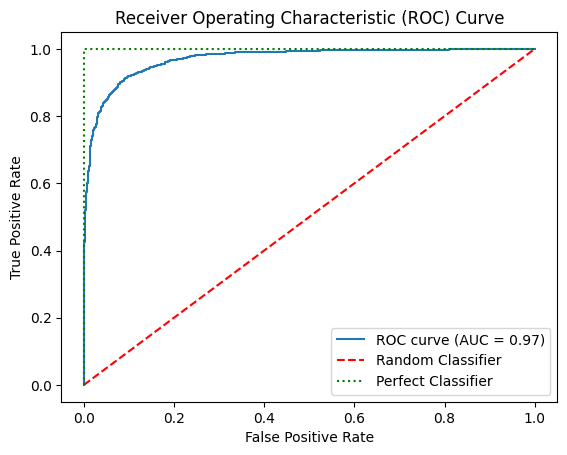

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Example predicted probabilities and true labels
predicted_probabilities = predictions
true_labels =y_test

# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)

# Calculate the Area Under the Curve (AUC)
auc = roc_auc_score(true_labels, predicted_probabilities)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Classifier')
plt.plot([0, 0, 1], [0, 1, 1], linestyle=':', color='g', label='Perfect Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()







In [ ]:
args_model = "modelnew.h5"
model.save(args_model)